In [1]:
import osmread
import numpy as np
import leuvenmapmatching
from pathlib import Path
import requests
import rtree
import pyproj
import matplotlib.pyplot as plt
import networkx as nx
import math
import random
import logging
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import smopy
import pandas as pd
from pathlib import Path
import requests
import geocoder

In [2]:
from leuvenmapmatching.map.inmem import InMemMap
from leuvenmapmatching.matcher.distance import DistanceMatcher
from leuvenmapmatching.util.gpx import gpx_to_path
from leuvenmapmatching import visualization as mmviz
from leuvenmapmatching import visualization as mm_viz

In [3]:
# парсим XML файл с OpenStreetMap через API, по координатам местности в г. Уфа

xml_file = Path(".") / "my_osm.xml"
url = 'http://overpass-api.de/api/map?bbox=55.852830,54.690987,55.862870, 54.700228'
r = requests.get(url, stream=True)
with xml_file.open('wb') as ofile:
    for chunk in r.iter_content(chunk_size=1024):
        if chunk:
            ofile.write(chunk)

In [4]:
# выбираем дороги, которые мы хотим использовать для создания ориентированного графа. Дороги с тегом «highway». 

map_con = InMemMap("myosm", use_latlon=True, use_rtree=True, index_edges=True)
for entity in osmread.parse_file(str(xml_file)):
    if isinstance(entity, osmread.Way) and 'highway' in entity.tags:
        for node_a, node_b in zip(entity.nodes, entity.nodes[1:]):
            map_con.add_edge(node_a, node_b)
            map_con.add_edge(node_b, node_a)
    if isinstance(entity, osmread.Node):
        map_con.add_node(entity.id, (entity.lat, entity.lon))
map_con.purge()

Lowered zoom level to keep map size reasonable. (z = 15)


(None, <AxesSubplot:xlabel='Longitude', ylabel='Latitude'>)

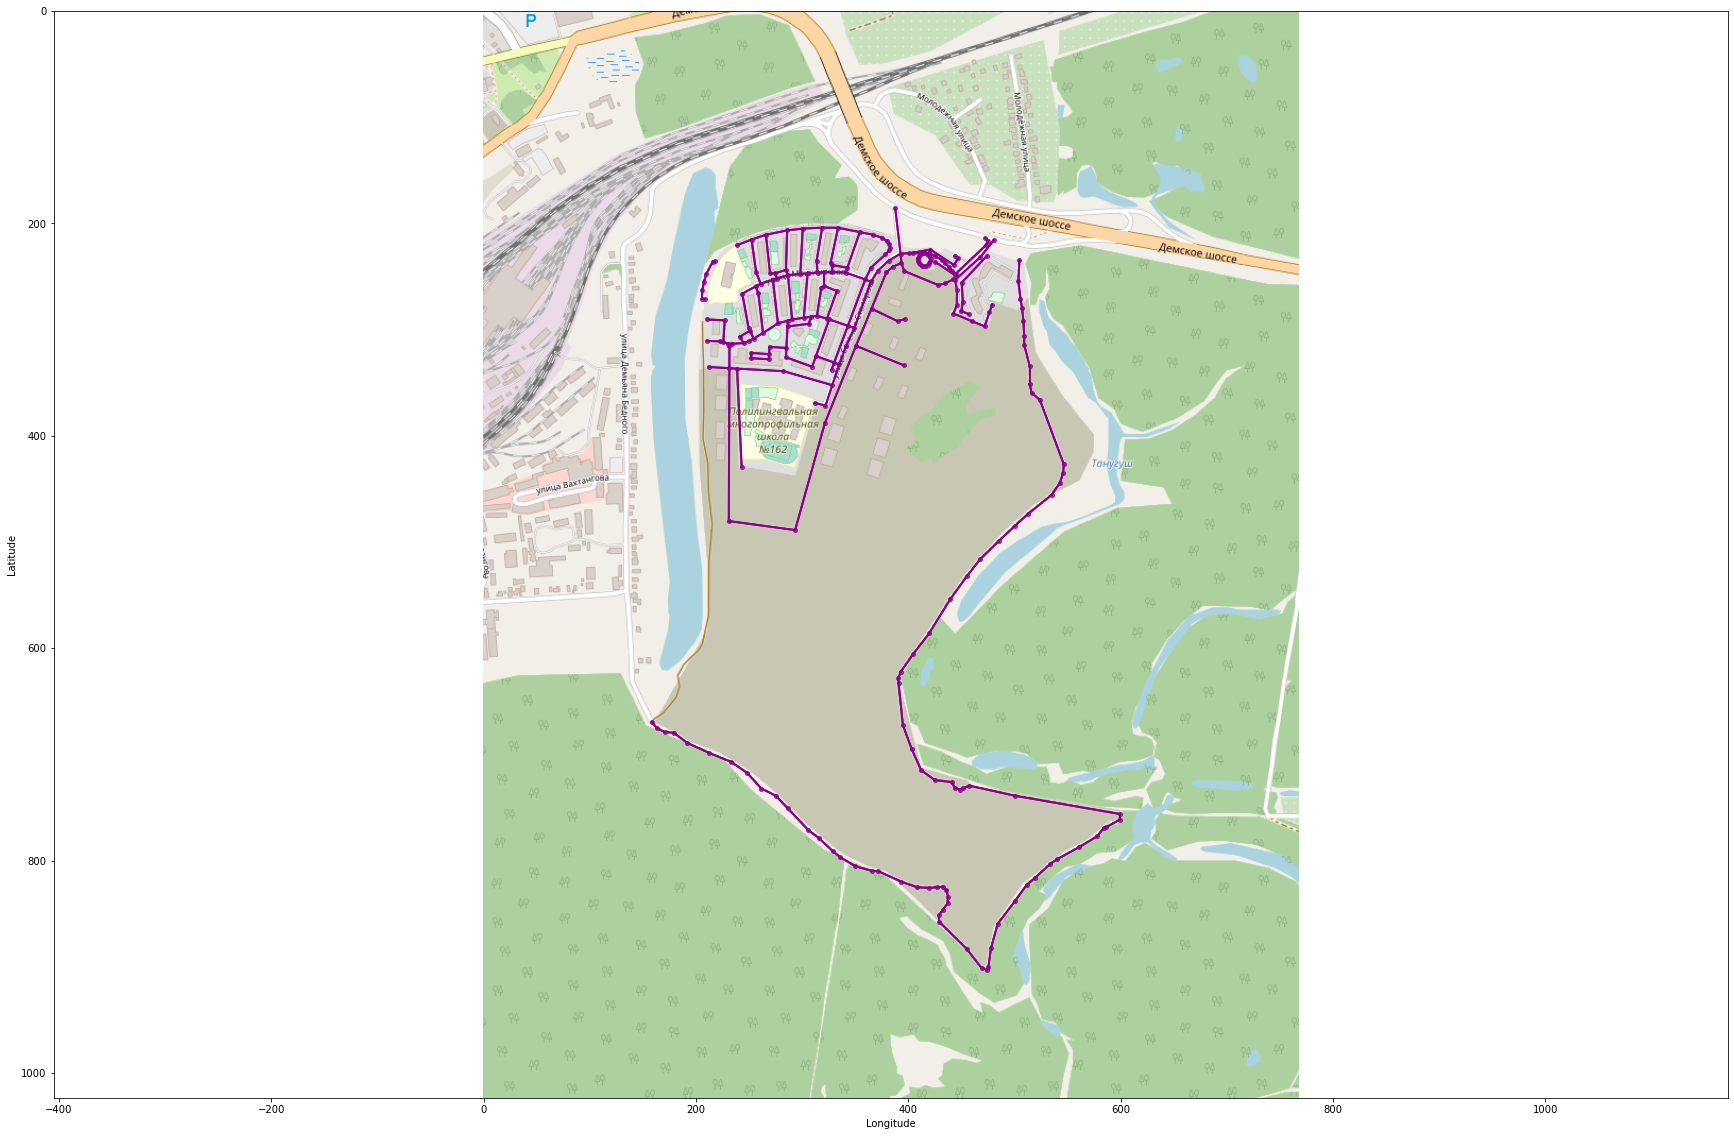

In [5]:
#визуализация дорожной карты графов
fig, ax = plt.subplots(figsize = (30,20))
mmviz.plot_map(map_con,
                use_osm=True, zoom_path=True, ax=ax,
                show_labels=False, show_matching=True, show_graph=True,
                filename="map_graph_osm_plot.png")

In [7]:
#GPS трек
track = [(54.698244, 55.855948),(54.698159, 55.855787), (54.698087, 55.855772),(54.697994, 55.855757),(54.697922, 55.855735),(54.697858, 55.855838),(54.697778, 55.855714), (54.697701, 55.855794),(54.697672, 55.855640), (54.697701, 55.855472),(54.697714, 55.855209),(54.697638, 55.855114),(54.697579, 55.855092),(54.697451, 55.855092),(54.697502, 55.854843),(54.697468, 55.854690),(54.697485, 55.854565)]

In [8]:
# Расчет расстояния и выбор ближащего подходящего ребра из графов местности
matcher = DistanceMatcher(map_con, max_dist=80, max_dist_init=30, min_prob_norm=0.001, non_emitting_length_factor=0.75, obs_noise=50, obs_noise_ne=80, non_emitting_states=True)
states, _ = matcher.match(track)

In [16]:
matcher.print_lattice_stats()
print(states)

Stats lattice
-------------
nbr levels               : 17
nbr lattice              : 608
avg lattice[level]       : 35.76470588235294
min lattice[level]       : 9
max lattice[level]       : 46
avg obs distance         : 3.064019861104279
last logprob             : -0.08310142810100103
last length              : 17
last norm logprob        : -0.004888319300058884
[(8777008083, 8777008080), (8777008080, 8777008024), (8777008080, 8777008024), (8777008080, 8777008024), (8777008080, 8777008024), (8777008080, 8777008024), (8777008080, 8777008024), (8777008080, 8777008024), (8777008024, 8777008023), (8777008024, 8777008023), (8777008024, 8777008023), (8777008023, 8777008019), (8777008023, 8777008019), (8777008019, 8777008022), (8777008022, 8777008021), (8777008022, 8777008021), (8777008022, 8777008021)]


(None, <AxesSubplot:xlabel='Longitude', ylabel='Latitude'>)

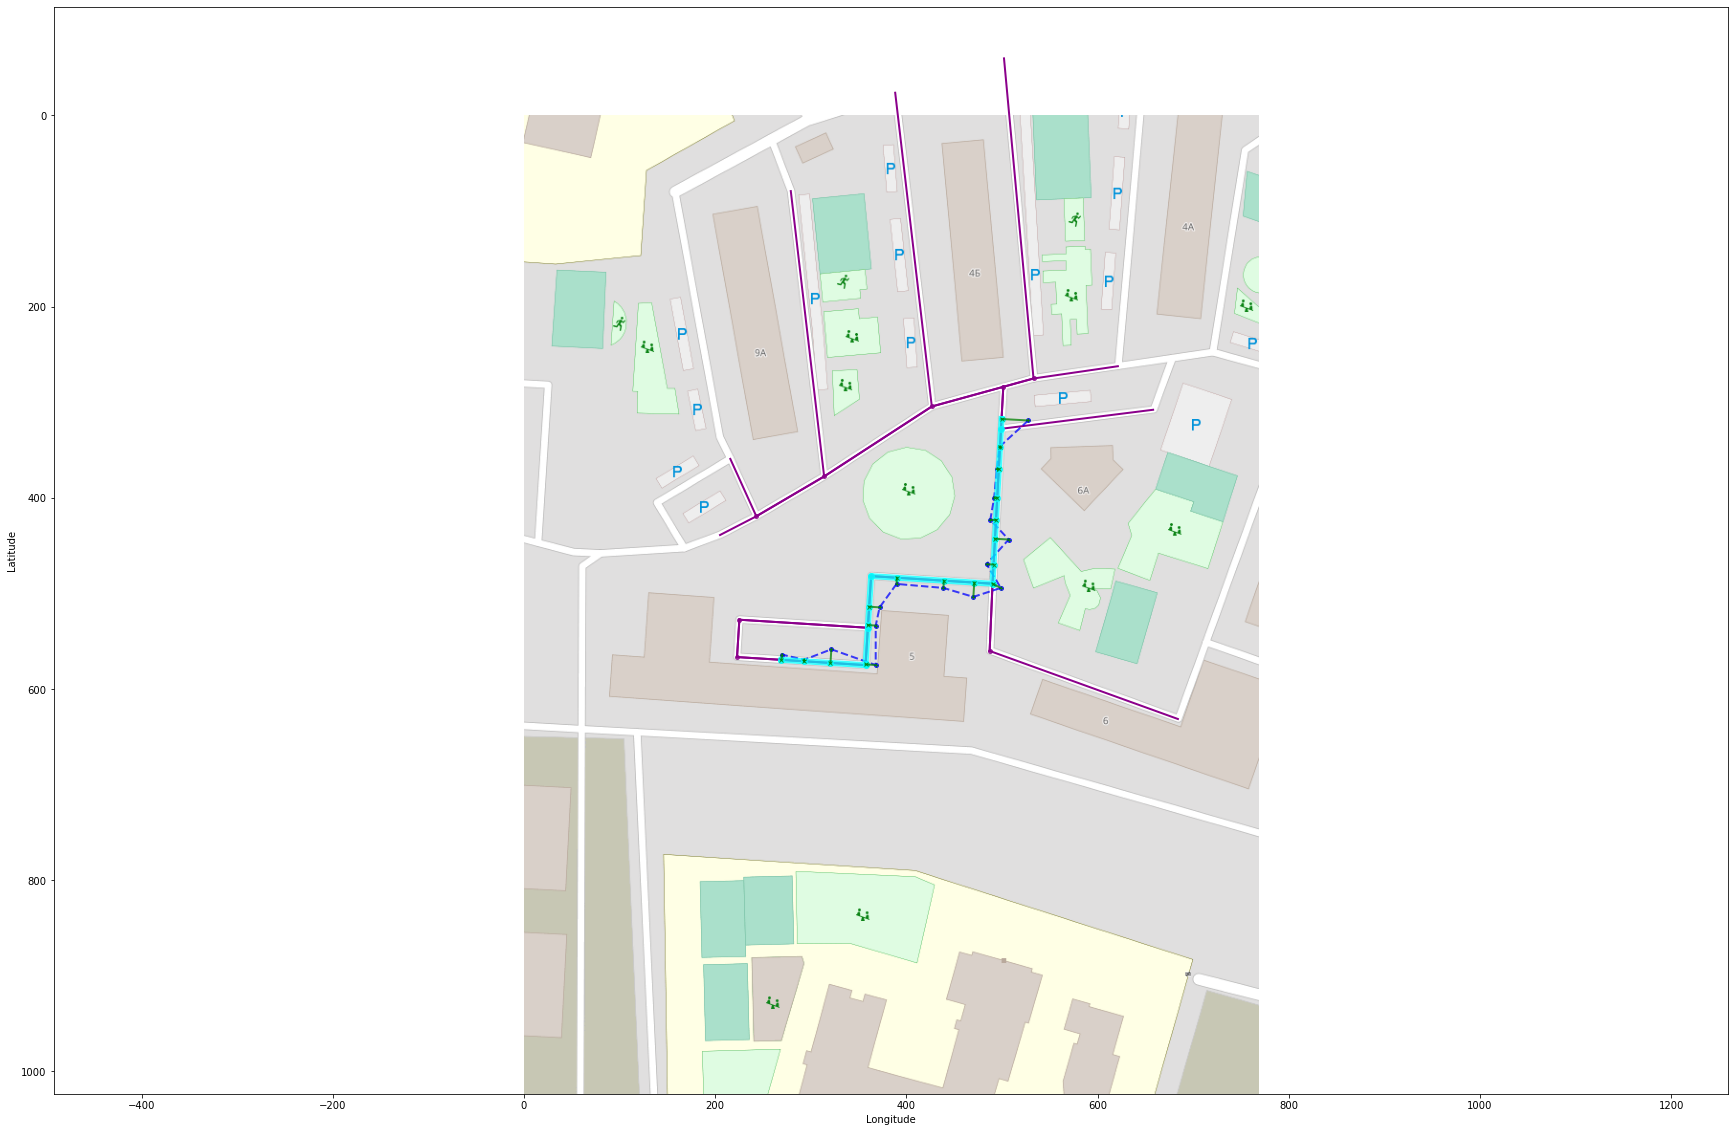

In [10]:
#визуализация метода - зеленые проекции на ребра наиболее вероятного ребра графа дороги, отображение маршрута (светло-синий)
#в основе лежит стохастическая модель, описывающая последовательность возможных событий, 
#в которых вероятность каждого события зависит только от состояния, достигнутого в предыдущем событии 
#графы дорог (фиолетовый) на карте OSM

fig, ax = plt.subplots(figsize = (30,20))
mmviz.plot_map(map_con,matcher=matcher,
                use_osm=True, zoom_path=True, ax=ax,
                show_labels=False, show_matching=True, show_graph=True,
                filename="HMM_method_osm_plot.png")

In [20]:
#Датафрейм принадлежности координат и дорог (ребер графа дорожной сети)

list_tuples = list(zip(states,track))

result = pd.DataFrame(list_tuples, columns=['highway', 'GPS'])
result

,highway,GPS
0,"(8777008083, 8777008080)","(54.698244, 55.855948)"
1,"(8777008080, 8777008024)","(54.698159, 55.855787)"
2,"(8777008080, 8777008024)","(54.698087, 55.855772)"
3,"(8777008080, 8777008024)","(54.697994, 55.855757)"
4,"(8777008080, 8777008024)","(54.697922, 55.855735)"
5,"(8777008080, 8777008024)","(54.697858, 55.855838)"
6,"(8777008080, 8777008024)","(54.697778, 55.855714)"
7,"(8777008080, 8777008024)","(54.697701, 55.855794)"
8,"(8777008024, 8777008023)","(54.697672, 55.85564)"
9,"(8777008024, 8777008023)","(54.697701, 55.855472)"
